In [0]:
#set the tesorflow version to 2 and import packages
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc2


In [0]:
#load the fashion mnist dataset from keras (code as given in the assignment specification pdf)
from keras.utils import np_utils

fashion_mnist = tf.keras.datasets.fashion_mnist

# load the training and test data    
(tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

# reshape the feature data
tr_x = tr_x.reshape(tr_x.shape[0], 784)
te_x = te_x.reshape(te_x.shape[0], 784)

# noramlise feature data
tr_x = tr_x / 255.0
te_x = te_x / 255.0

print( "Shape of training features ", tr_x.shape)
print( "Shape of test features ", te_x.shape)


# one hot encode the training labels and get the transpose
tr_y = np_utils.to_categorical(tr_y,10)
tr_y = tr_y.T
print ("Shape of training labels ", tr_y.shape)

# one hot encode the test labels and get the transpose
te_y = np_utils.to_categorical(te_y,10)
te_y = te_y.T
print ("Shape of testing labels ", te_y.shape)

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (10, 60000)
Shape of testing labels  (10, 10000)


In [0]:
#Reshape the training and test data so that features become the rows
tr_x = tf.cast(tr_x.T, tf.float32)
te_x = tf.cast(te_x.T,tf.float32)
print("Train features data shape : ",tr_x.shape)
print("Test features data shape : ",te_x.shape)

Train features data shape :  (784, 60000)
Test features data shape :  (784, 10000)


In [0]:
#forward_pass, relu_layer and softmax activation function
def softmax_activation(x):
  step_1 = tf.math.exp(x)
  step_2 = step_1/(tf.math.reduce_sum(step_1,axis = 0))
  return step_2

def relu_layer(data, coefficients, bias):
  H = tf.math.add(tf.matmul(coefficients, data), bias)
  #zeros = tf.zeros([H.shape[0],H.shape[1]],tf.float32)
  return tf.math.maximum(H,0.0)

def forward_pass(tr_x, coefficients1, bias1, coefficients2, bias2, coefficients3, bias3):
  H1 = relu_layer(tr_x, coefficients1, bias1)
  H2 = relu_layer(H1, coefficients2, bias2)
  prediction = softmax_activation(tf.math.add(tf.matmul(coefficients3, H2), bias3)) 
  return prediction

In [0]:
#cross_entropy function with L1 regularization
def cross_entropy_l1_regularization(predictions, tr_y, coefficients1, coefficients2, coefficients3):
  delta = tf.constant(0.00001,tf.float32)
  loss = tf.math.reduce_sum(tf.math.negative(tf.multiply(tr_y,tf.math.log(predictions))),axis = 0)
  loss = tf.math.reduce_mean(loss)
  reg = tf.multiply(delta,tf.math.add(tf.math.reduce_sum(coefficients1),tf.math.add(tf.math.reduce_sum(coefficients2),tf.math.reduce_sum(coefficients3))))
  return tf.math.add(loss,reg)
  

In [0]:
#cross_entropy function with L2 regularization
def cross_entropy_l2_regularization(predictions, tr_y, coefficients1, coefficients2, coefficients3):
  delta = tf.constant(0.001,tf.float32)
  loss = tf.math.reduce_sum(tf.math.negative(tf.multiply(tr_y,tf.math.log(predictions))),axis = 0)
  loss = tf.math.reduce_sum(loss)/tr_y.shape[1]
  reg = tf.multiply(delta,tf.math.add(tf.math.reduce_sum(tf.math.pow(coefficients1,2)),
                                      tf.math.add(tf.math.reduce_sum(tf.math.pow(coefficients2,2)),
                                                  tf.math.reduce_sum(tf.math.pow(coefficients3,2)))))
  return tf.math.add(loss,reg)



In [0]:
#calculate_accuracy function
def calculate_accuracy(predictions, tr_y):
  max_prob_predictions = tf.math.argmax(predictions)
  max_prob_tr_y = tf.math.argmax(tr_y)
  result = tf.reduce_sum(tf.cast(tf.equal(max_prob_predictions, max_prob_tr_y), tf.float32))
  return result/tr_y.shape[1]*100

In [0]:
#model for L1 regularization
#create and initialize 6 tensorflow variables- coefficients1, coefficients2 and coefficients3 with random values and the bias1, bias2 and bias3 with 0.0
coefficients1 = tf.Variable(tf.random.normal([ 300,tr_x.shape[0]], mean=0.0, stddev=0.05, seed = 100))
bias1 = tf.Variable([0.], dtype = tf.float32)
coefficients2 = tf.Variable(tf.random.normal([ 100,300], mean=0.0, stddev=0.05, seed = 100))
bias2 = tf.Variable([0.], dtype = tf.float32)
coefficients3 = tf.Variable(tf.random.normal([ 10, 100 ], mean=0.0, stddev=0.05, seed = 100))
bias3 = tf.Variable([0.], dtype = tf.float32)

max_iter = 200
adam_optimizer = tf.keras.optimizers.Adam()

training_loss = []
training_accuracy = []
testing_accuracy = []
testing_loss = []

for i in range(max_iter):

  #recording the predictions and loss for train and test data for every iteration using the gradient tape
  with tf.GradientTape() as tape:

    predictions = forward_pass(tr_x,coefficients1, bias1, coefficients2, bias2, coefficients3, bias3)
    loss = cross_entropy_l1_regularization(predictions, tr_y, coefficients1, coefficients2, coefficients3)
    training_loss.append(loss)
    
    #testing tthe model with test data
    test_predictions = forward_pass(te_x,coefficients1, bias1, coefficients2, bias2, coefficients3, bias3)
    test_loss = cross_entropy_l1_regularization(test_predictions, te_y, coefficients1, coefficients2, coefficients3)
    testing_loss.append(test_loss)
  
  #computing train accuracy
  trainAccuracy = calculate_accuracy(predictions, tr_y)
  training_accuracy.append(trainAccuracy)

  #computing test accuracy
  testAccuracy = calculate_accuracy(test_predictions, te_y)
  testing_accuracy.append(testAccuracy)

  #updating the coefficients and bias with the loss from the gradient tape
  gradients = tape.gradient(loss, [coefficients1, bias1, coefficients2, bias2, coefficients3, bias3])
  adam_optimizer.apply_gradients(zip(gradients, [coefficients1,bias1,coefficients2, bias2, coefficients3, bias3]))



Train Accuracy : 88.88333
Test Accuracy : 86.81


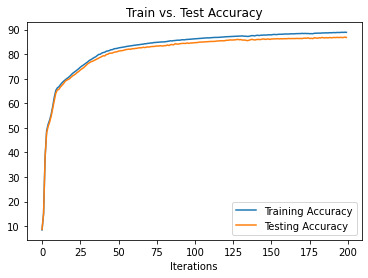

Train Loss : 0.21563703
Test Loss : 0.27156886


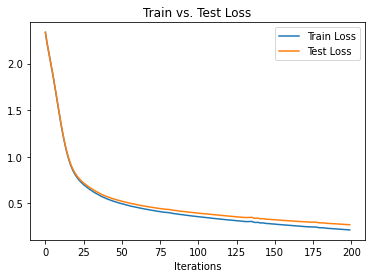

In [0]:
#evaluation of L1 regularization model
#printing final train and test accuracy
print("Train Accuracy :", trainAccuracy.numpy())
print("Test Accuracy :", testAccuracy.numpy())

#plot for the train vs. test accuracy
plt.plot(training_accuracy, label = 'Training Accuracy')
plt.plot(testing_accuracy, label = 'Testing Accuracy')
plt.title('Train vs. Test Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()

#printing final train and test loss
print("Train Loss :", loss.numpy())
print("Test Loss :", test_loss.numpy())


#plot for the train vs. test loss
plt.plot(training_loss, label = 'Train Loss')
plt.plot(testing_loss, label = 'Test Loss')
plt.title('Train vs. Test Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [0]:
#model for L2 regularization
#create and initialize 6 tensorflow variables- coefficients1, coefficients2 and coefficients3 with random values and the bias1, bias2 and bias3 with 0.0
coefficients1 = tf.Variable(tf.random.normal([ 300,tr_x.shape[0]], mean=0.0, stddev=0.05, seed = 100))
bias1 = tf.Variable([0.], dtype = tf.float32)
coefficients2 = tf.Variable(tf.random.normal([ 100,300], mean=0.0, stddev=0.05, seed = 100))
bias2 = tf.Variable([0.], dtype = tf.float32)
coefficients3 = tf.Variable(tf.random.normal([ 10, 100 ], mean=0.0, stddev=0.05, seed = 100))
bias3 = tf.Variable([0.], dtype = tf.float32)

max_iter = 200
adam_optimizer = tf.keras.optimizers.Adam()

training_loss_l2 = []
training_accuracy_l2 = []
testing_accuracy_l2 = []
testing_loss_l2 = []

for i in range(max_iter):

  #recording the predictions and loss for train and test data for every iteration using the gradient tape
  with tf.GradientTape() as tape:

    predictions = forward_pass(tr_x,coefficients1, bias1, coefficients2, bias2, coefficients3, bias3)
    loss = cross_entropy_l2_regularization(predictions, tr_y, coefficients1, coefficients2, coefficients3)
    training_loss_l2.append(loss)
    
    #testing tthe model with test data
    test_predictions = forward_pass(te_x,coefficients1, bias1, coefficients2, bias2, coefficients3, bias3)
    test_loss = cross_entropy_l2_regularization(test_predictions, te_y, coefficients1, coefficients2, coefficients3)
    testing_loss_l2.append(test_loss)
  
  #computing train accuracy
  trainAccuracy = calculate_accuracy(predictions, tr_y)
  training_accuracy_l2.append(trainAccuracy)

  #computing test accuracy
  testAccuracy = calculate_accuracy(test_predictions, te_y)
  testing_accuracy_l2.append(testAccuracy)

  #updating the coefficients and bias with the loss from the gradient tape
  gradients = tape.gradient(loss, [coefficients1, bias1, coefficients2, bias2, coefficients3, bias3])
  adam_optimizer.apply_gradients(zip(gradients, [coefficients1,bias1,coefficients2, bias2, coefficients3, bias3]))

Train Accuracy : 86.98334
Test Accuracy : 85.2


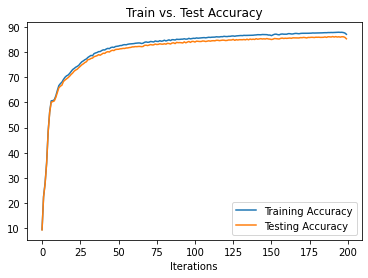

Train Loss : 0.5575844
Test Loss : 0.59923


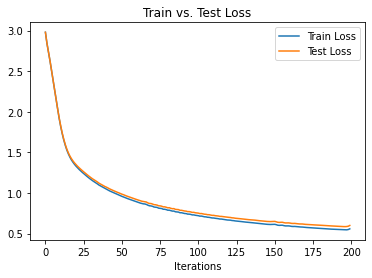

In [0]:
#evaluation of L2 regularization model
#printing final train and test accuracy
print("Train Accuracy :", trainAccuracy.numpy())
print("Test Accuracy :", testAccuracy.numpy())

#plot for the train vs. test accuracy
plt.plot(training_accuracy_l2, label = 'Training Accuracy')
plt.plot(testing_accuracy_l2, label = 'Testing Accuracy')
plt.title('Train vs. Test Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()

#printing final train and test loss
print("Train Loss :", loss.numpy())
print("Test Loss :", test_loss.numpy())


#plot for the train vs. test loss
plt.plot(training_loss_l2, label = 'Train Loss')
plt.plot(testing_loss_l2, label = 'Test Loss')
plt.title('Train vs. Test Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()